# Playground Competition Season 04 Episode 03
Here I will investigate depth and width of the NN. From the previous, 001, I have gotten 'Vanilla' scores that serve as a reference for improvement.

| Model       | Focus area             | Submitted AUC score |
|-------------|------------------------|---------------------|
| Vanilla 0.1 | None                   | 0.54859             |
| Vanilla 0.2 | Standardize input data | 0.57534             |
| Vanilla 0.3 | Re-sampling data       | 0.49236             |
| Lemon   1.0 | Default 3-layers       | 0.85335             |

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

train_data = pd.read_csv('/kaggle/input/playground-series-s4e3/train.csv', index_col='id')
test_data = pd.read_csv('/kaggle/input/playground-series-s4e3/test.csv', index_col='id')

# Seperate X,y
prediction_categories = train_data.columns.drop(test_data.columns)
X_full = train_data.drop(prediction_categories, axis=1)
y_full = train_data[prediction_categories].copy()
assert(X_full.shape[1] == test_data.shape[1])

# Lemon 1.0, Adding flavour
I will build a function to build a model of various depth and width, then investigate how this model will perform.

In [2]:
from sklearn.model_selection import train_test_split
# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X_full, y_full, train_size=0.8, test_size=0.2)
X_test = test_data.copy()

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Pick columns with a 'large' mean, 
# I will chose 2.5 just to avoid manipulation the Log-based categories
cols_to_std = [c for c in X_train.columns if X_train[c].mean() > 2.5]

# Bundle preprocessing for numerical and categorical data
my_preprocessor = ColumnTransformer(
    transformers=[
        ('large mean', StandardScaler(), cols_to_std),
    ])
X_train[cols_to_std] = my_preprocessor.fit_transform(X_train)
X_valid[cols_to_std] = my_preprocessor.transform(X_valid)
X_test[cols_to_std] = my_preprocessor.transform(test_data)

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input

num_classes = y_train.shape[1]
num_features = X_train.shape[1]

def get_model(learning_rate=0.3,layers=[64,32,16]) -> Sequential:
    # Create a Sequential model
    model = Sequential()
    model.add(Input(shape=(num_features,)))
    #model.add(Dense(units=128,activation='relu'))
    for n in layers:
        model.add(Dense(units=n,activation='relu'))
        
    model.add(Dense(units=num_classes, activation='softmax'))
    #model.layers[0].input_shape = (num_features,)

    # Compile the model
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',  # Use categorical cross-entropy for multi-class classification
                  metrics=['accuracy','auc'])

    # Name the model
    model.name = 'Lemon' 
    return model
model = get_model()
# Print model summary
model.summary()

2024-03-03 21:21:45.995768: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-03 21:21:45.995896: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-03 21:21:46.154566: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Model: "Lemon"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           119 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,519 (17.65 KB)

 Trainable params: 4,519 (17.65 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
def get_early_stopping(patience=25,min_delta=0.001) -> EarlyStopping:
    return EarlyStopping(monitor='val_loss',
                         patience=patience, 
                         min_delta=min_delta,
                         restore_best_weights=True,
                         verbose=0,
                        )

# Helper func to display metrics from training history
def print_metrics(history) -> None:
    idx = np.argmin(history.history['val_loss'])
    print(f'Epochs until best result: {idx}')
    print(f'Best validation accuracy: {history.history["val_accuracy"][idx]}')
    print(f'Best validation auc     : {history.history["auc"][idx]}')
    print(f'Best validation loss    : {history.history["val_loss"][idx]}')
    
# Helper func to plot metrics from training history
def plot_metrics(history,start=1) -> None:
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    history_df = pd.DataFrame(history.history)
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot loss and val_loss
    loss_plot = history_df.loc[start:, ['loss', 'val_loss']].plot(ax=axes[0], title="Categorical Cross-Entropy")
    loss_plot.set_xlabel("Epoch")

    # Plot accuracy and val_accuracy
    accuracy_plot = history_df.loc[start:, ['accuracy', 'val_accuracy']].plot(ax=axes[1], title="Accuracy")
    accuracy_plot.set_xlabel("Epoch")

    # Plot auc and val_auc
    auc_plot = history_df.loc[start:, ['auc', 'val_auc']].plot(ax=axes[2], title="AUC")
    auc_plot.set_xlabel("Epoch")

    plt.tight_layout()  # Adjust spacing between plots
    plt.show()

In [6]:
def train_model(model,verbose=0):
    early_stopping = get_early_stopping()
    
    history = model.fit(
        X_train,y_train,
        validation_data=(X_valid,y_valid),
        batch_size=512,
        epochs=200,
        callbacks=[early_stopping],
        verbose=verbose
    )

    return model,history

## Lemon 1.0
For 1.0 I will simply run the default model parameters and evaluate its score.

In [7]:
# Get a new model, although keep the learning rate at 0.0001
model = get_model(learning_rate=0.0001)
print(f'New model: {model.name}')
# Train the model
model,history = train_model(model)

New model: Lemon


Epochs until best result: 103
Best validation accuracy: 0.5460457801818848
Best validation auc     : 0.9090281128883362
Best validation loss    : 0.963374674320221


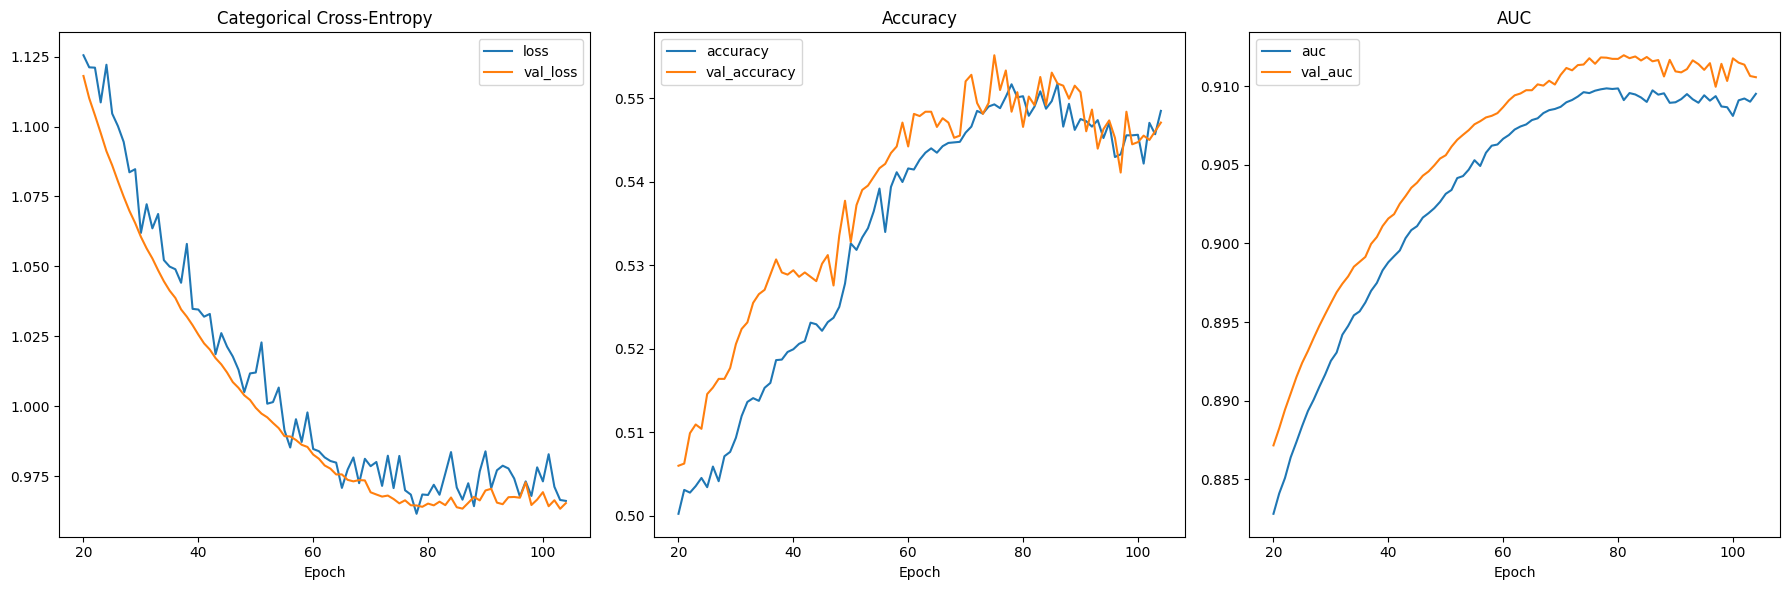

In [8]:
# Plot the metrics
print_metrics(history)
plot_metrics(history,start=20)

### Conclusion
Looking at AUC there is a big bump up from the vanilla model. Experimenting with depth and width could give us better predictions.

## Lemon 1.1
Lets create a dictionary of a few different widths and depths, create models and see which ever has the best performance.

New model: Lemon with layers: [16, 16, 16]
Epochs until best result: 173
Best validation accuracy: 0.5489073991775513
Best validation auc     : 0.9063911437988281
Best validation loss    : 0.9755604863166809


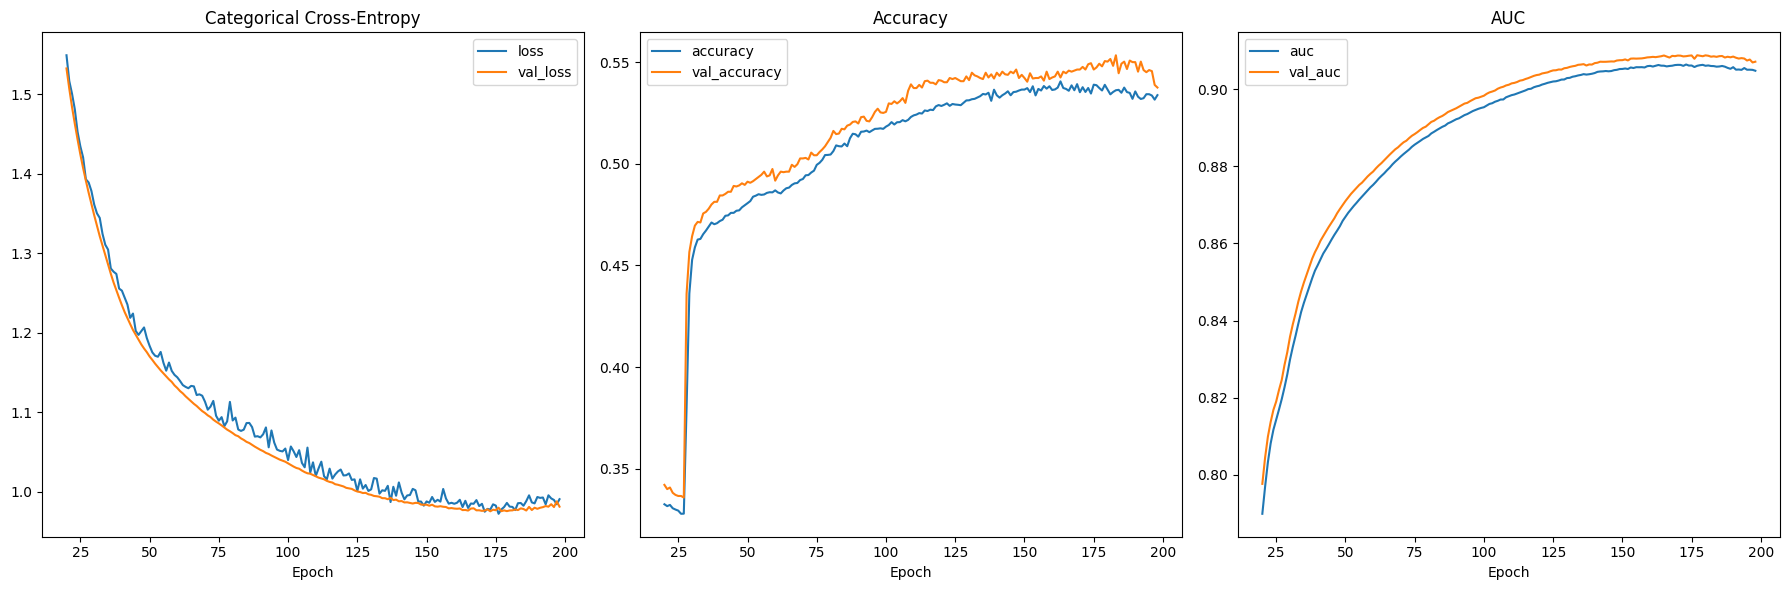

New model: Lemon with layers: [16, 16, 16, 16]
Epochs until best result: 129
Best validation accuracy: 0.5330384969711304
Best validation auc     : 0.8960003852844238
Best validation loss    : 1.0150209665298462


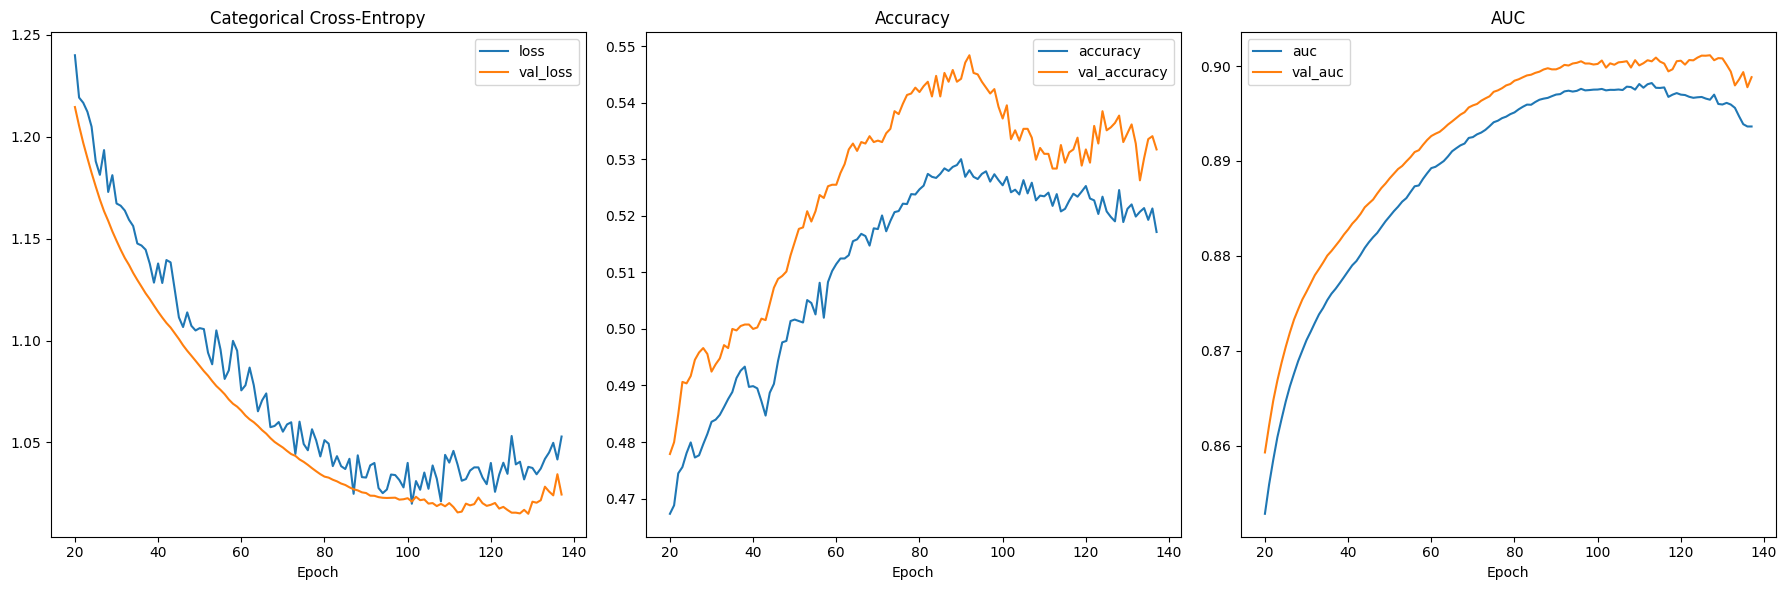

New model: Lemon with layers: [16, 16, 16, 16, 16]
Epochs until best result: 83
Best validation accuracy: 0.5215920805931091
Best validation auc     : 0.8905165195465088
Best validation loss    : 1.064252257347107


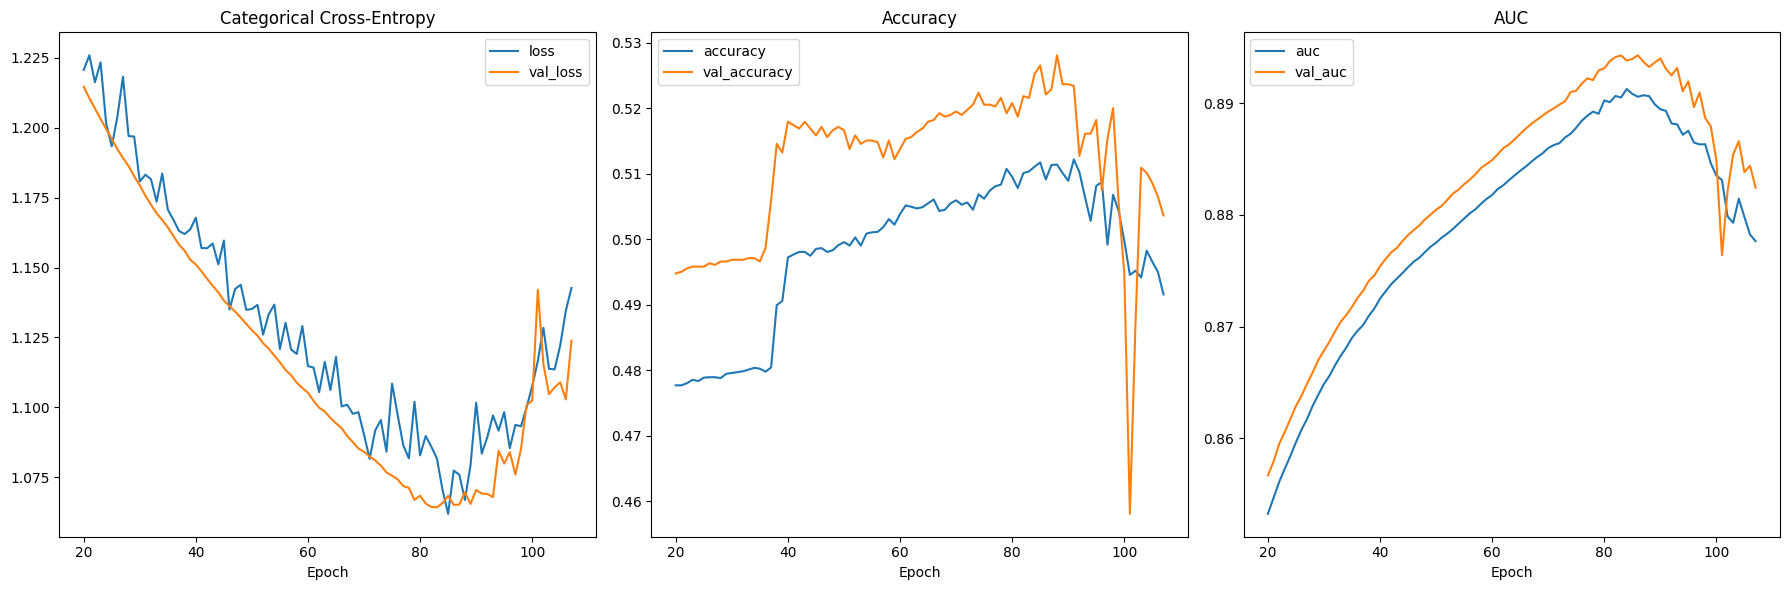

New model: Lemon with layers: [32, 16, 16]
Epochs until best result: 122
Best validation accuracy: 0.5520291328430176
Best validation auc     : 0.9056693315505981
Best validation loss    : 0.9831765294075012


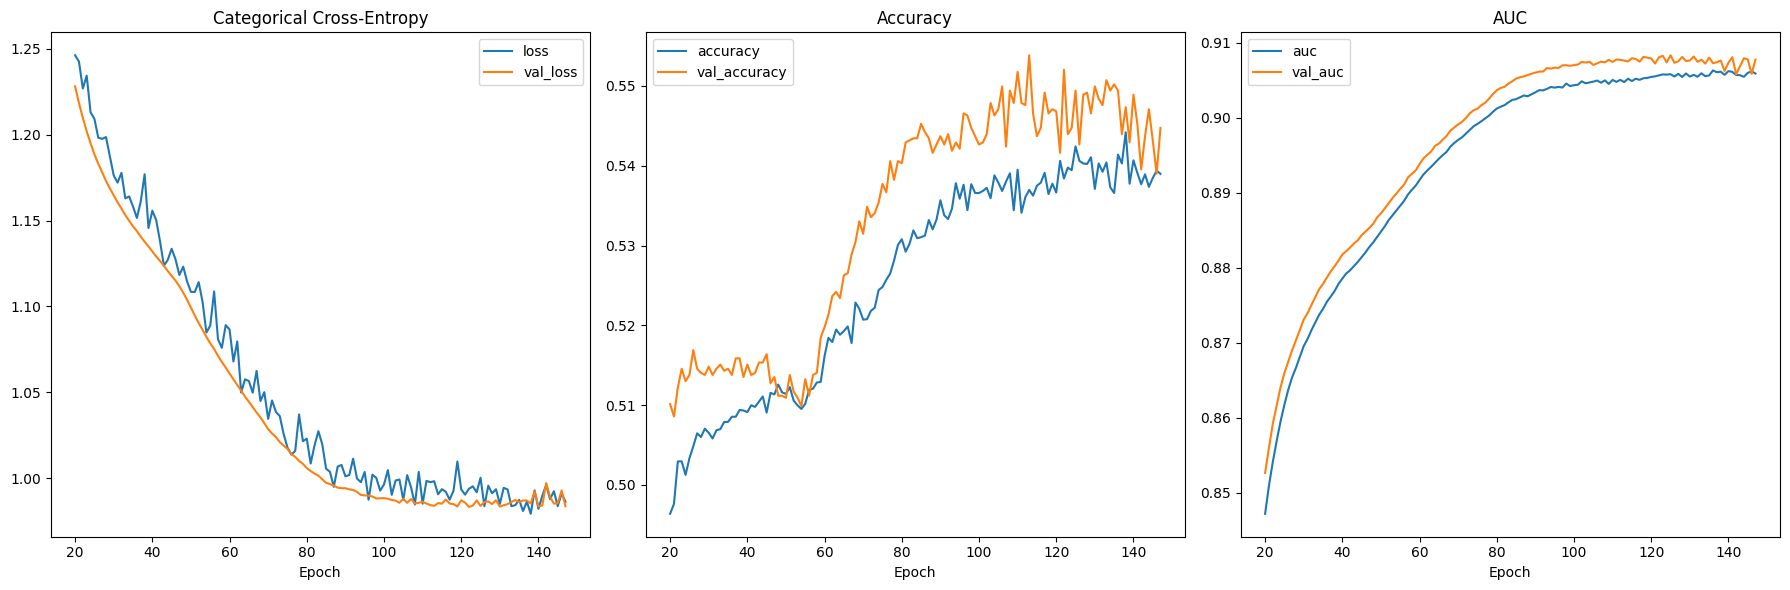

New model: Lemon with layers: [32, 16, 16, 16]
Epochs until best result: 95
Best validation accuracy: 0.5379812717437744
Best validation auc     : 0.8964085578918457
Best validation loss    : 1.0262738466262817


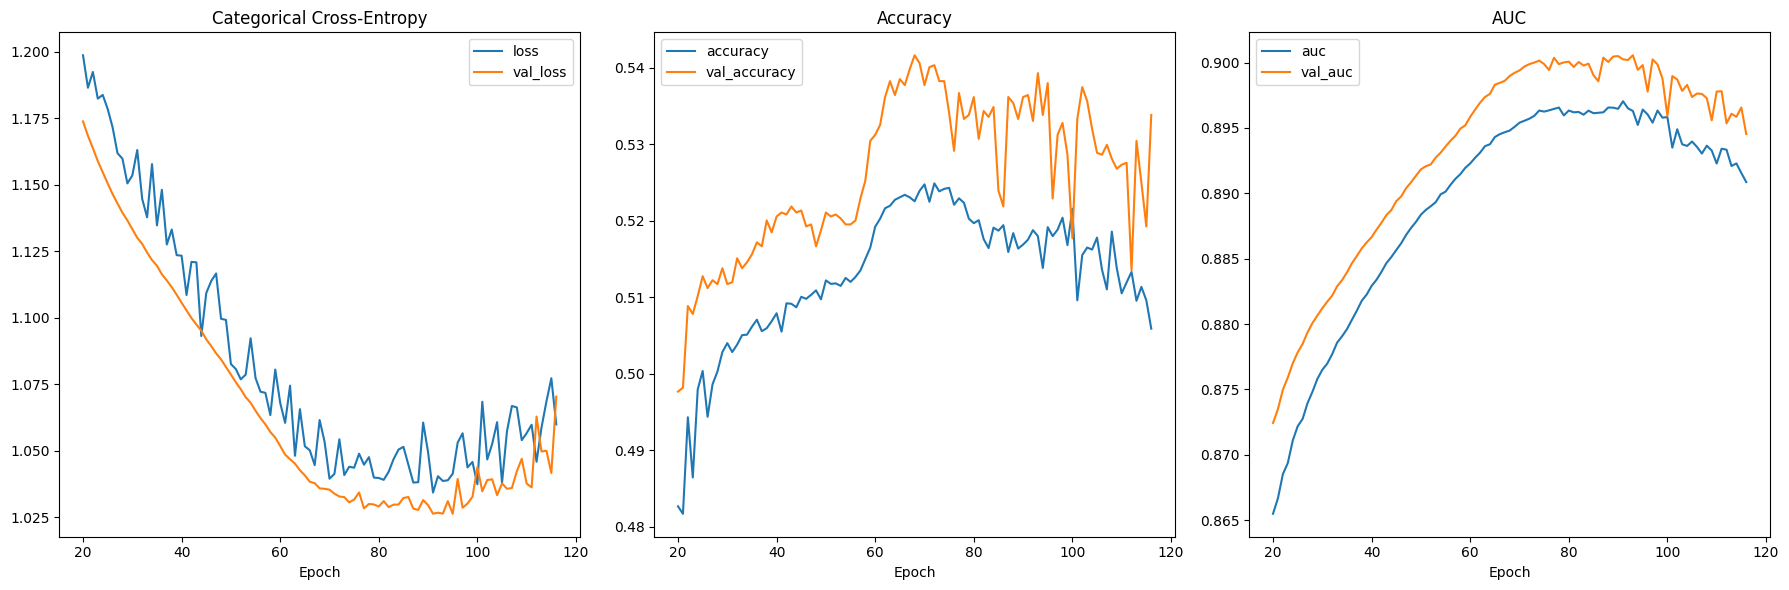

New model: Lemon with layers: [32, 16, 16, 16, 16]
Epochs until best result: 65
Best validation accuracy: 0.533298671245575
Best validation auc     : 0.8983425498008728
Best validation loss    : 1.0180463790893555


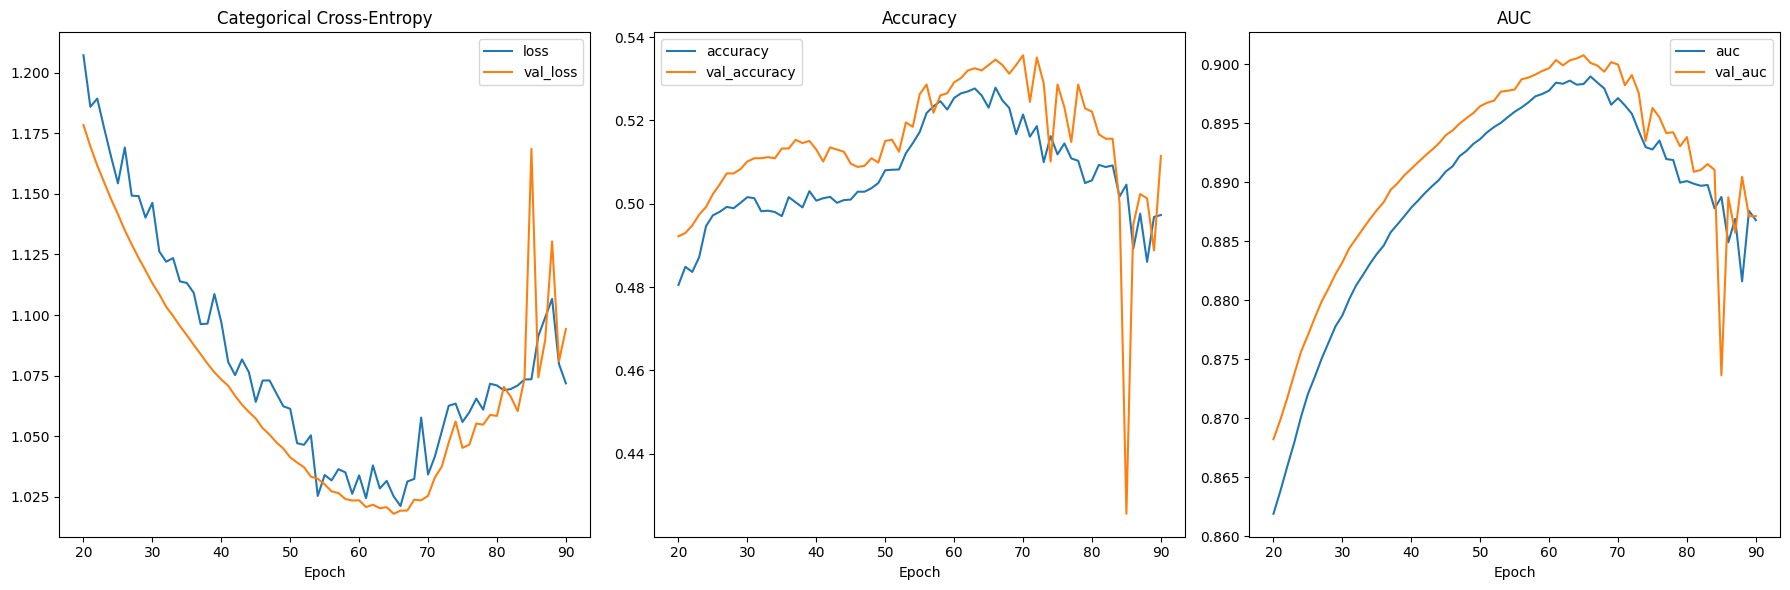

New model: Lemon with layers: [32, 32, 16]
Epochs until best result: 112
Best validation accuracy: 0.5522893071174622
Best validation auc     : 0.9092782139778137
Best validation loss    : 0.9555655121803284


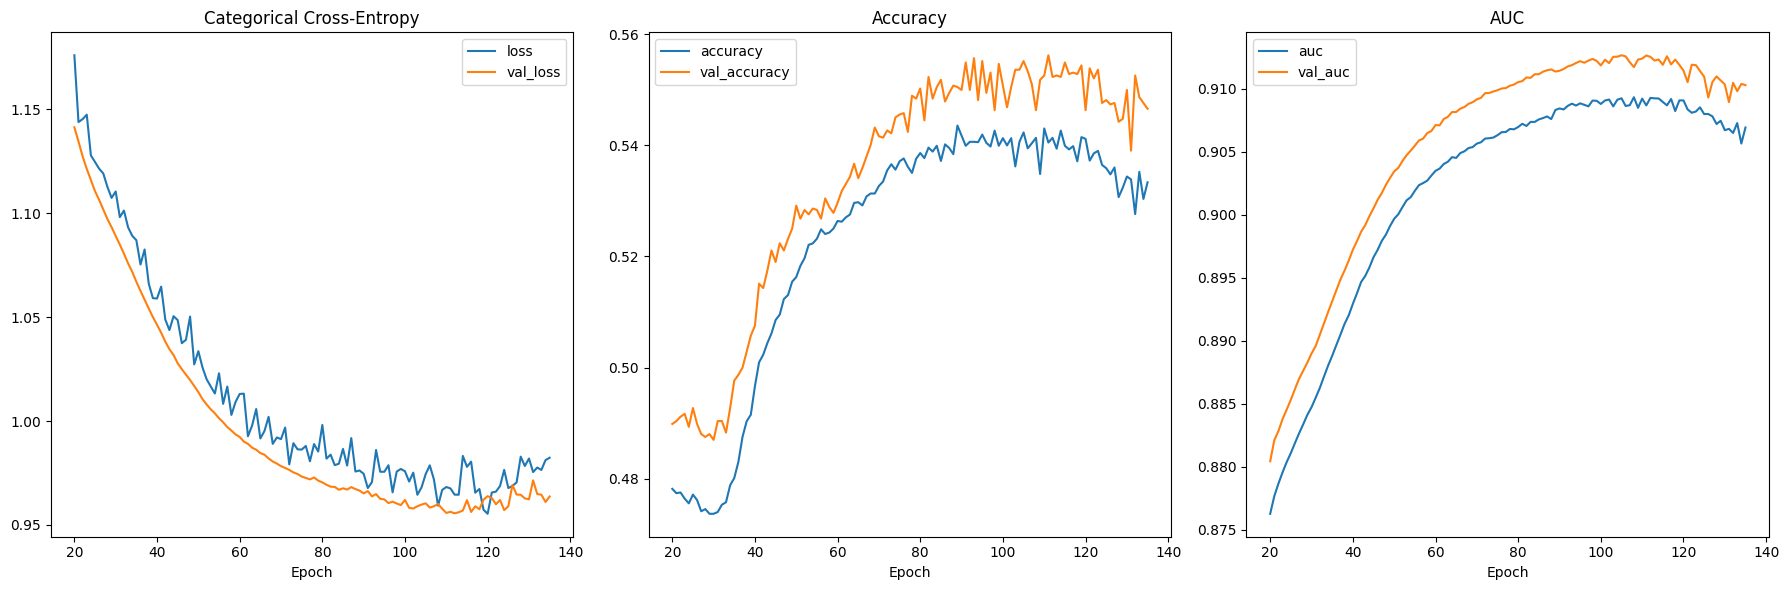

New model: Lemon with layers: [32, 32, 32]
Epochs until best result: 86
Best validation accuracy: 0.5473465323448181
Best validation auc     : 0.9043741226196289
Best validation loss    : 0.9887093305587769


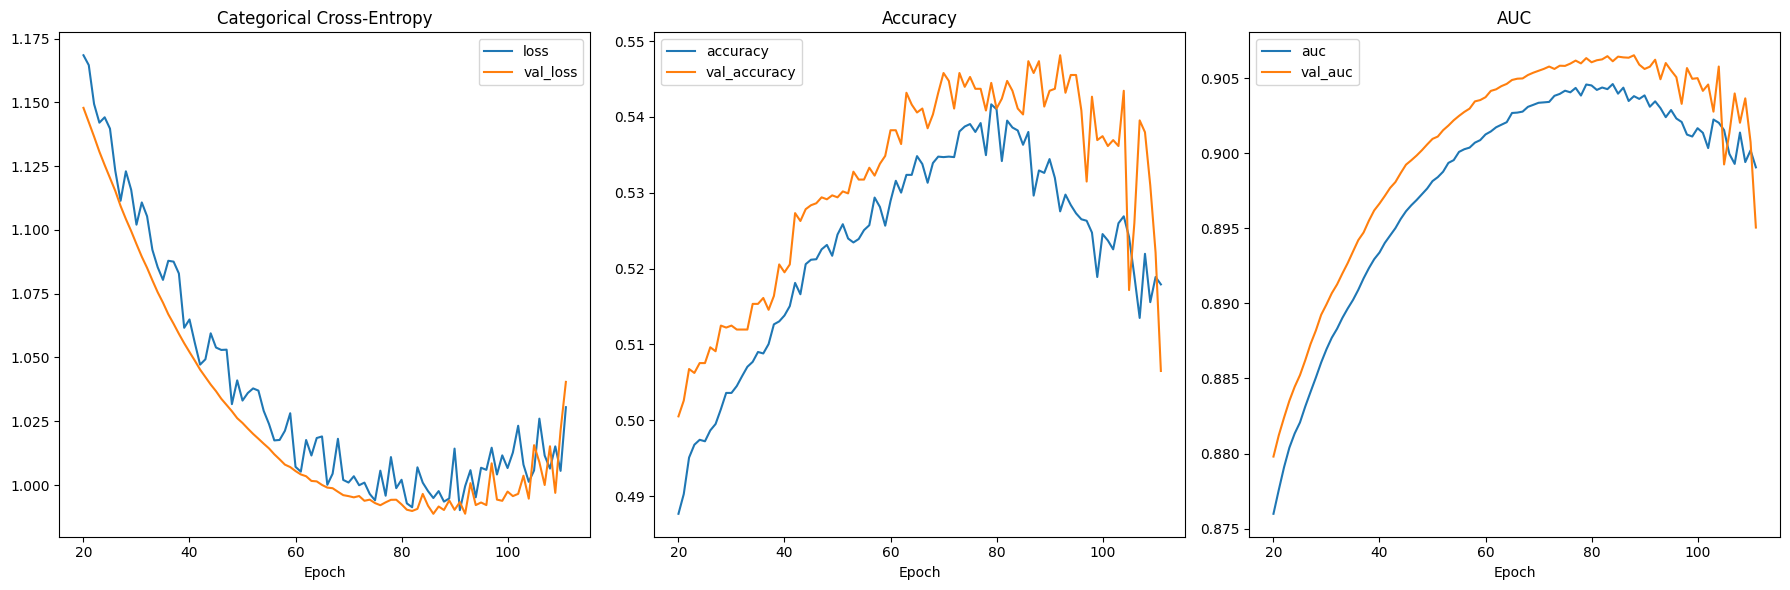

New model: Lemon with layers: [64, 16, 16]
Epochs until best result: 109
Best validation accuracy: 0.556711733341217
Best validation auc     : 0.9077012538909912
Best validation loss    : 0.963188886642456


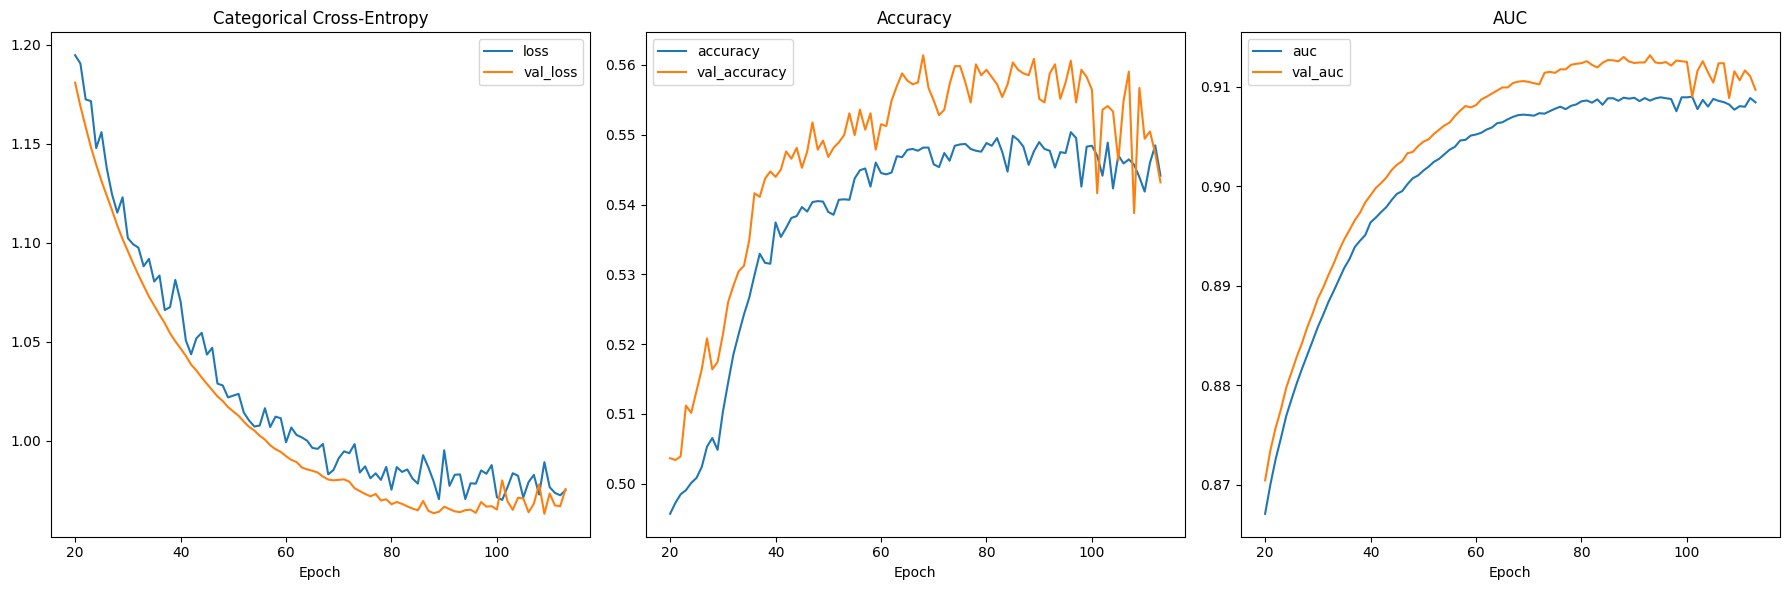

New model: Lemon with layers: [64, 32, 16]
Epochs until best result: 92
Best validation accuracy: 0.5465660691261292
Best validation auc     : 0.9073970317840576
Best validation loss    : 0.9602408409118652


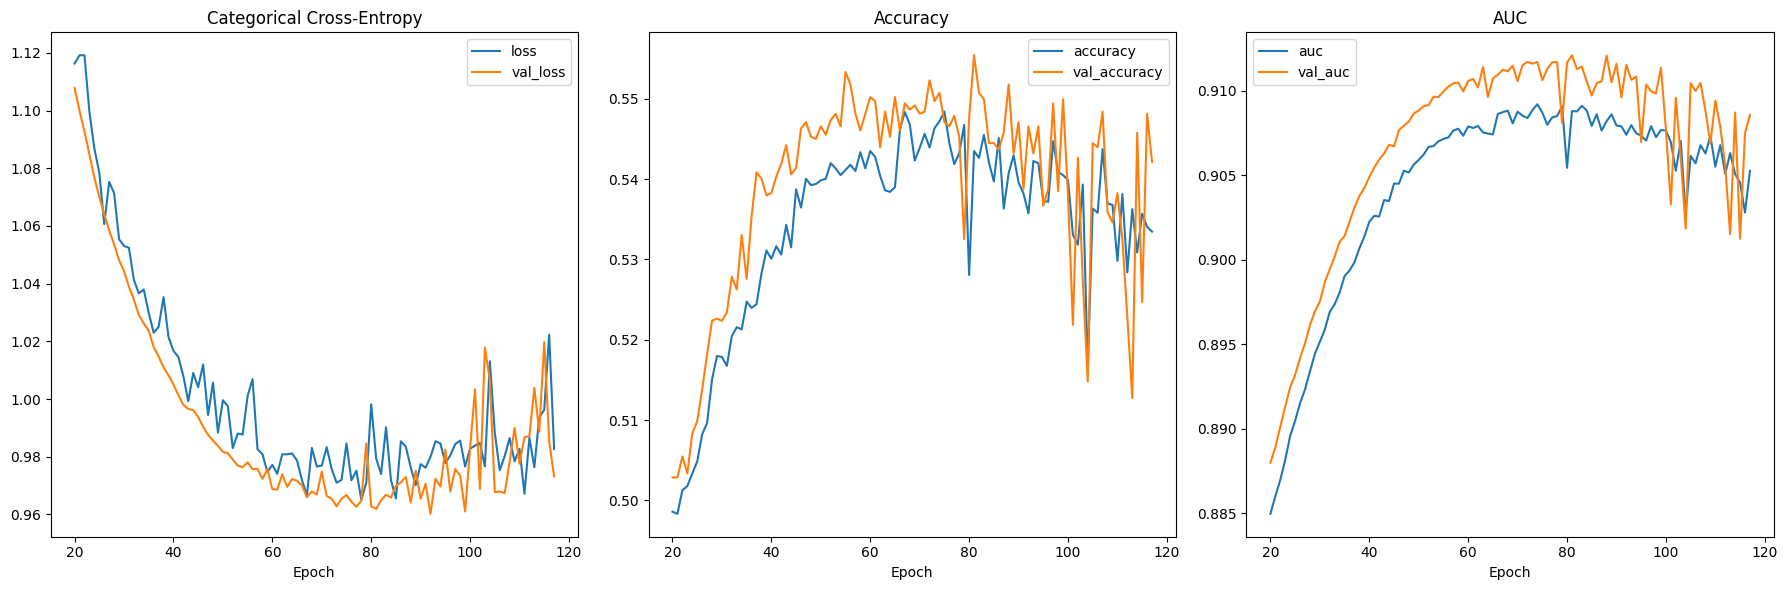

New model: Lemon with layers: [64, 32, 32]
Epochs until best result: 78
Best validation accuracy: 0.5486472249031067
Best validation auc     : 0.9104709029197693
Best validation loss    : 0.9583109021186829


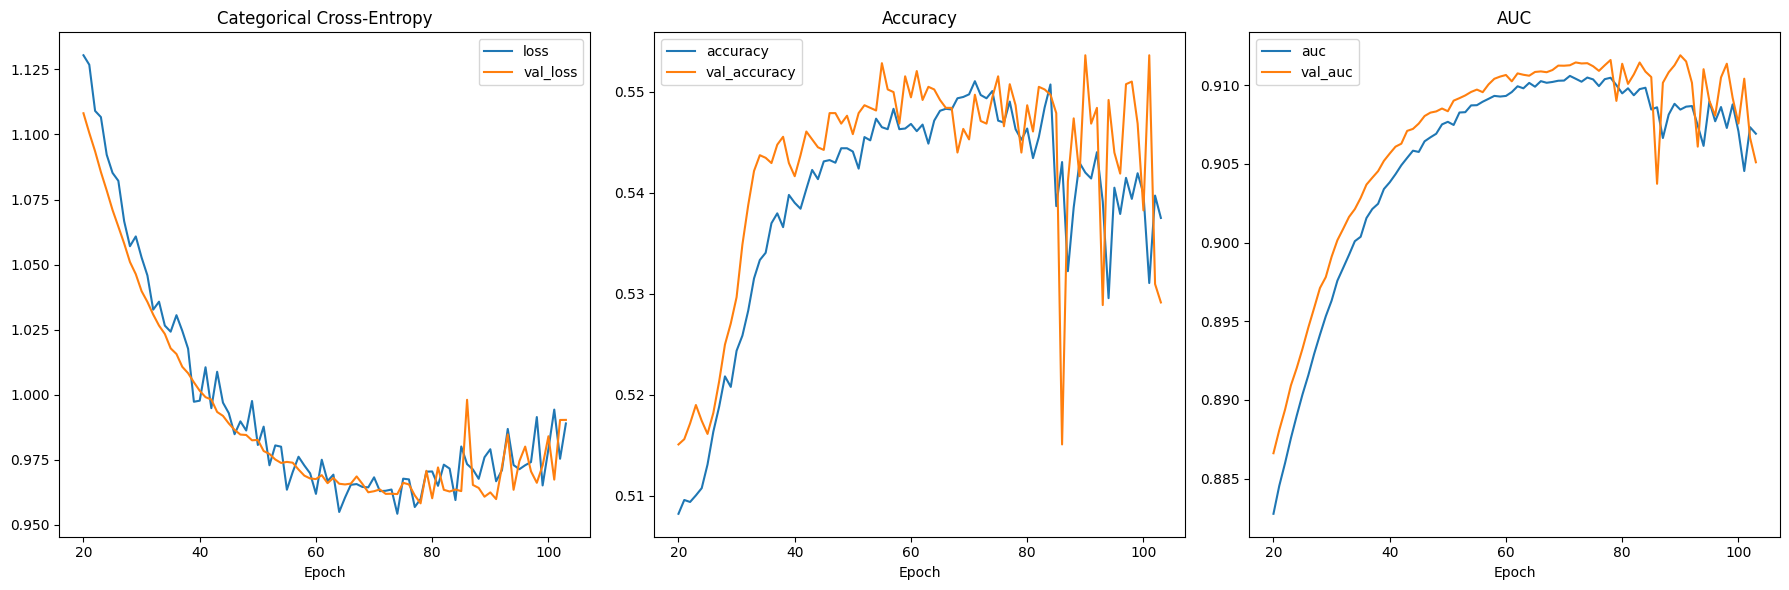

New model: Lemon with layers: [64, 64, 16]
Epochs until best result: 61
Best validation accuracy: 0.5520291328430176
Best validation auc     : 0.907543420791626
Best validation loss    : 0.9661495685577393


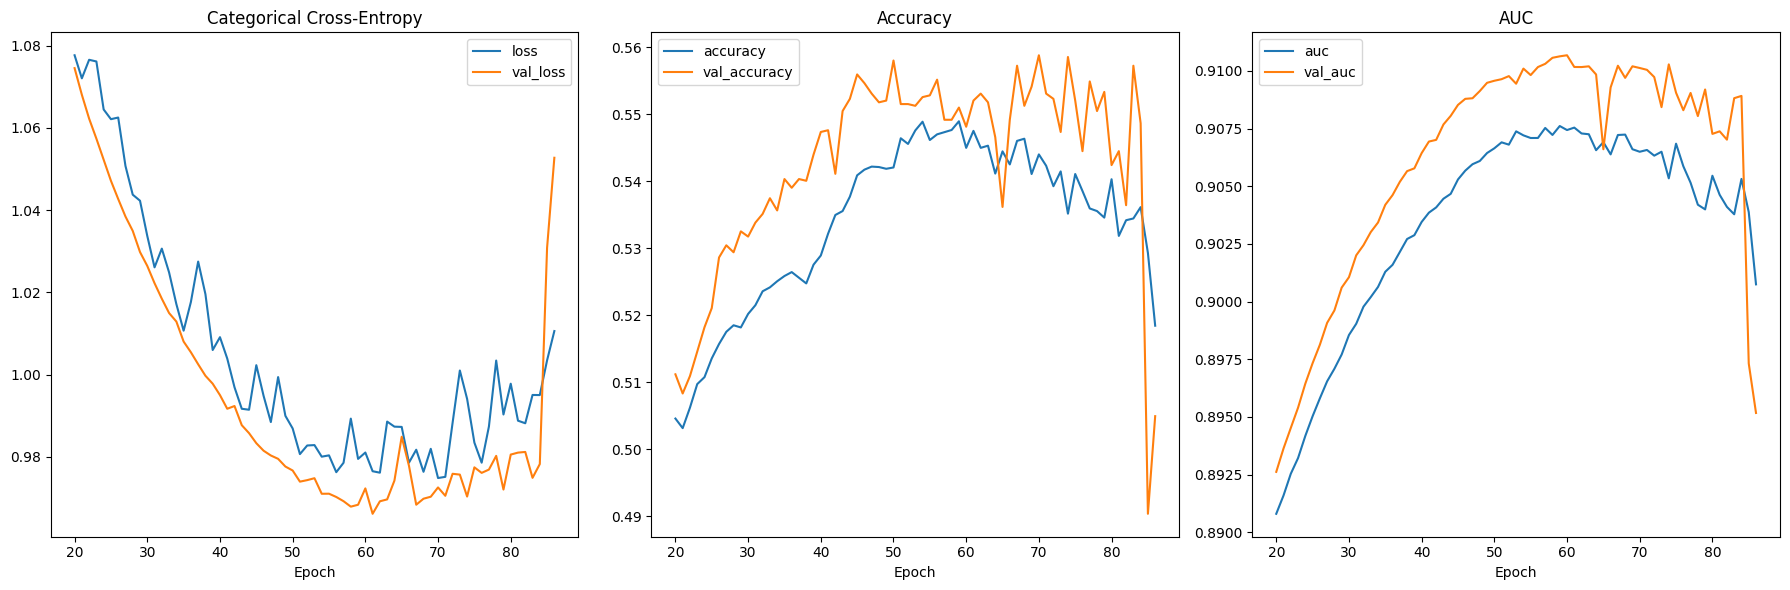

New model: Lemon with layers: [64, 64, 64]
Epochs until best result: 37
Best validation accuracy: 0.5491675138473511
Best validation auc     : 0.9065153002738953
Best validation loss    : 0.9733308553695679


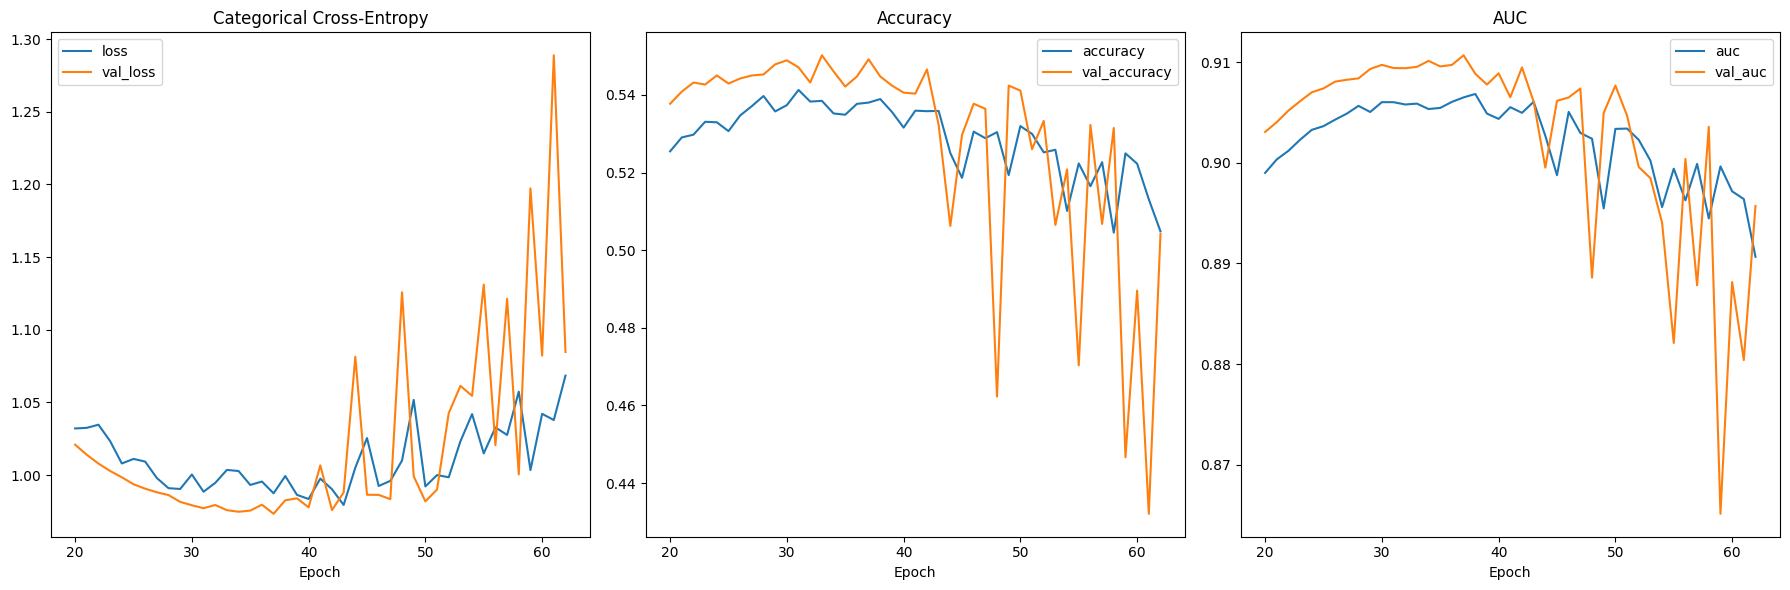

New model: Lemon with layers: [128, 16, 16]
Epochs until best result: 83
Best validation accuracy: 0.5548907518386841
Best validation auc     : 0.9109333157539368
Best validation loss    : 0.9486792683601379


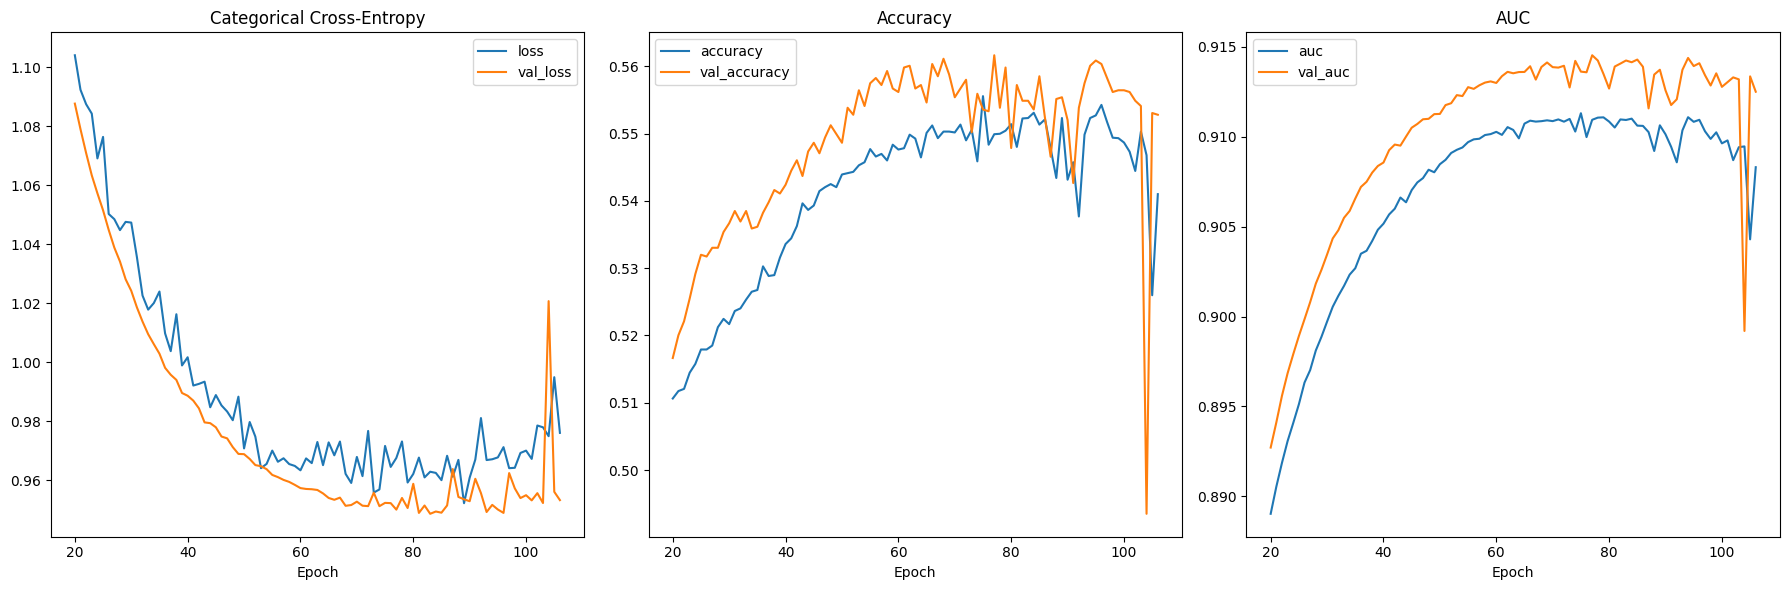

New model: Lemon with layers: [128, 32, 16]
Epochs until best result: 112
Best validation accuracy: 0.5587929487228394
Best validation auc     : 0.9121824502944946
Best validation loss    : 0.9486595392227173


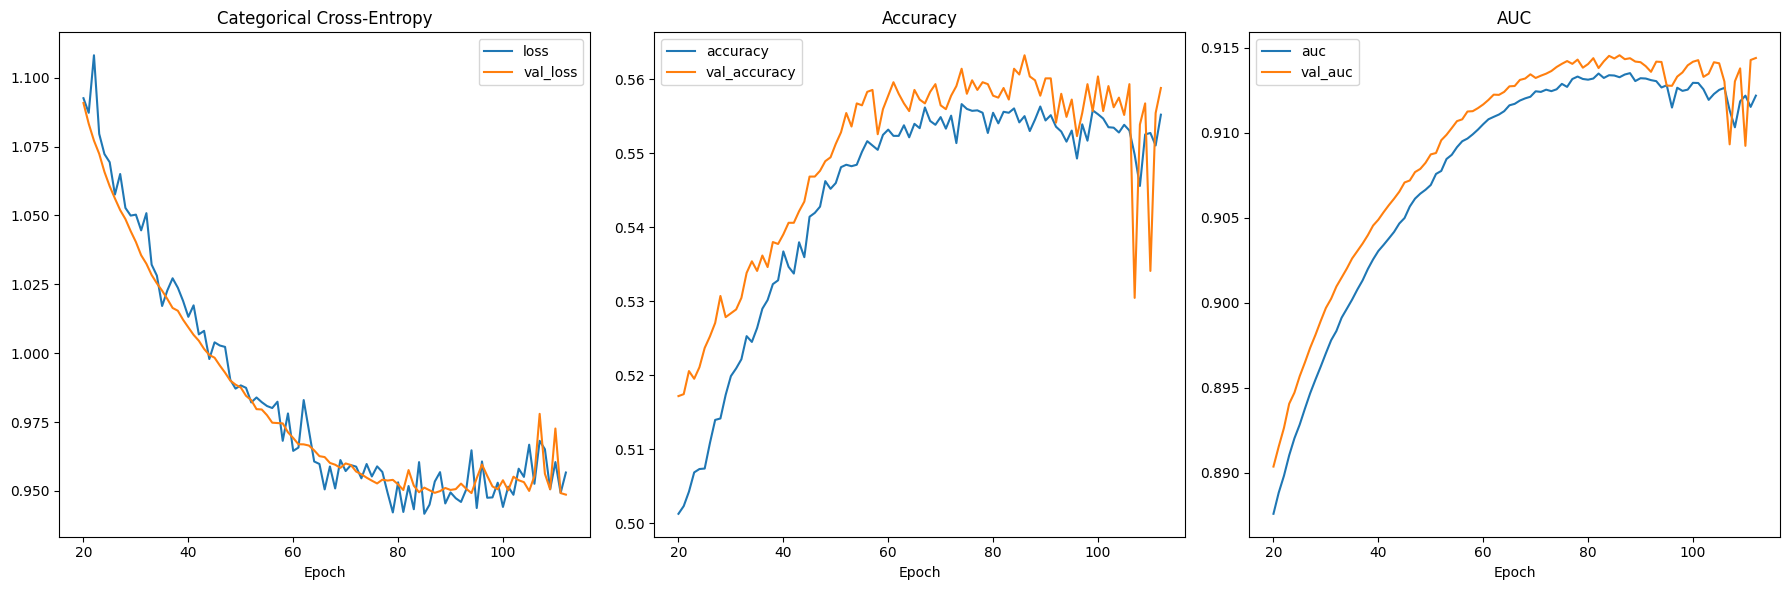

New model: Lemon with layers: [128, 32, 32]
Epochs until best result: 56
Best validation accuracy: 0.558272659778595
Best validation auc     : 0.9116674661636353
Best validation loss    : 0.9473357796669006


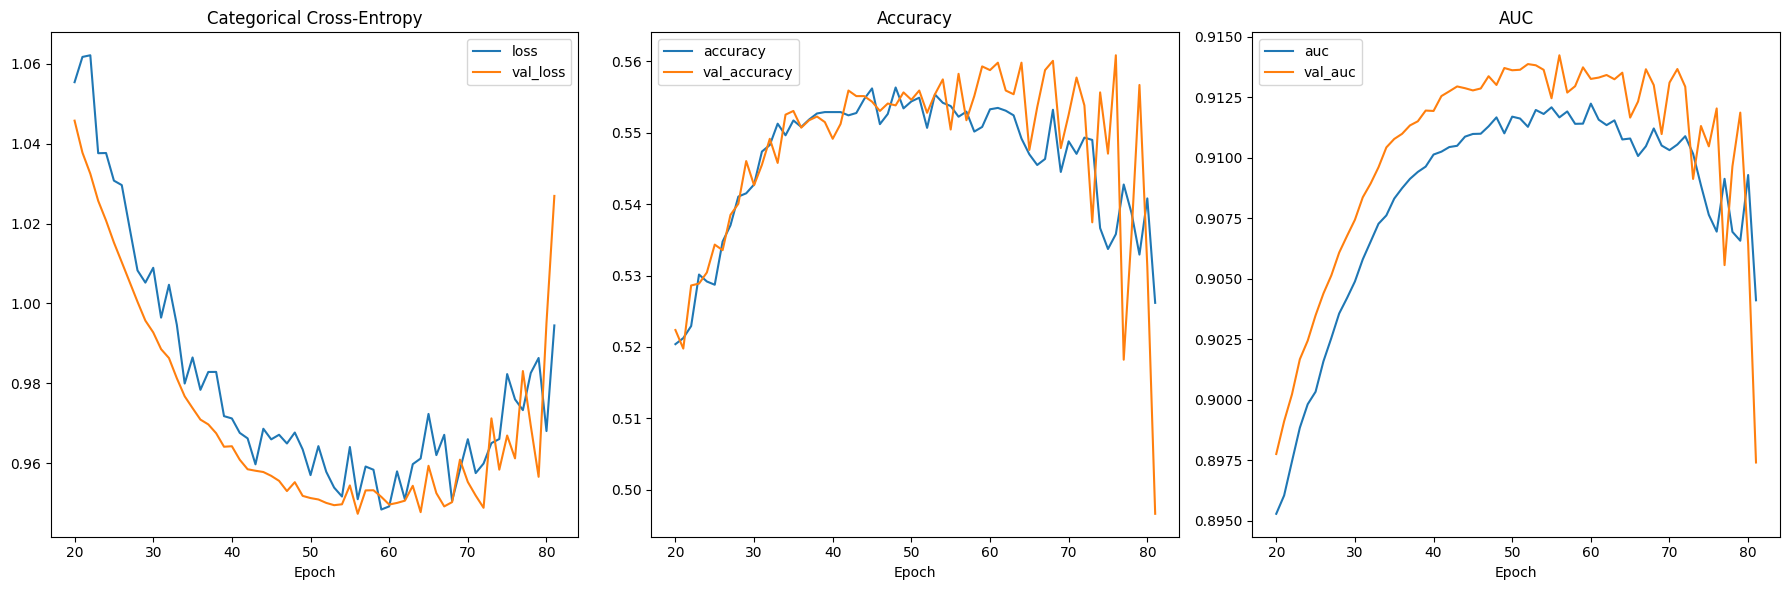

New model: Lemon with layers: [128, 64, 16]
Epochs until best result: 47
Best validation accuracy: 0.5535899996757507
Best validation auc     : 0.9101725816726685
Best validation loss    : 0.9600545167922974


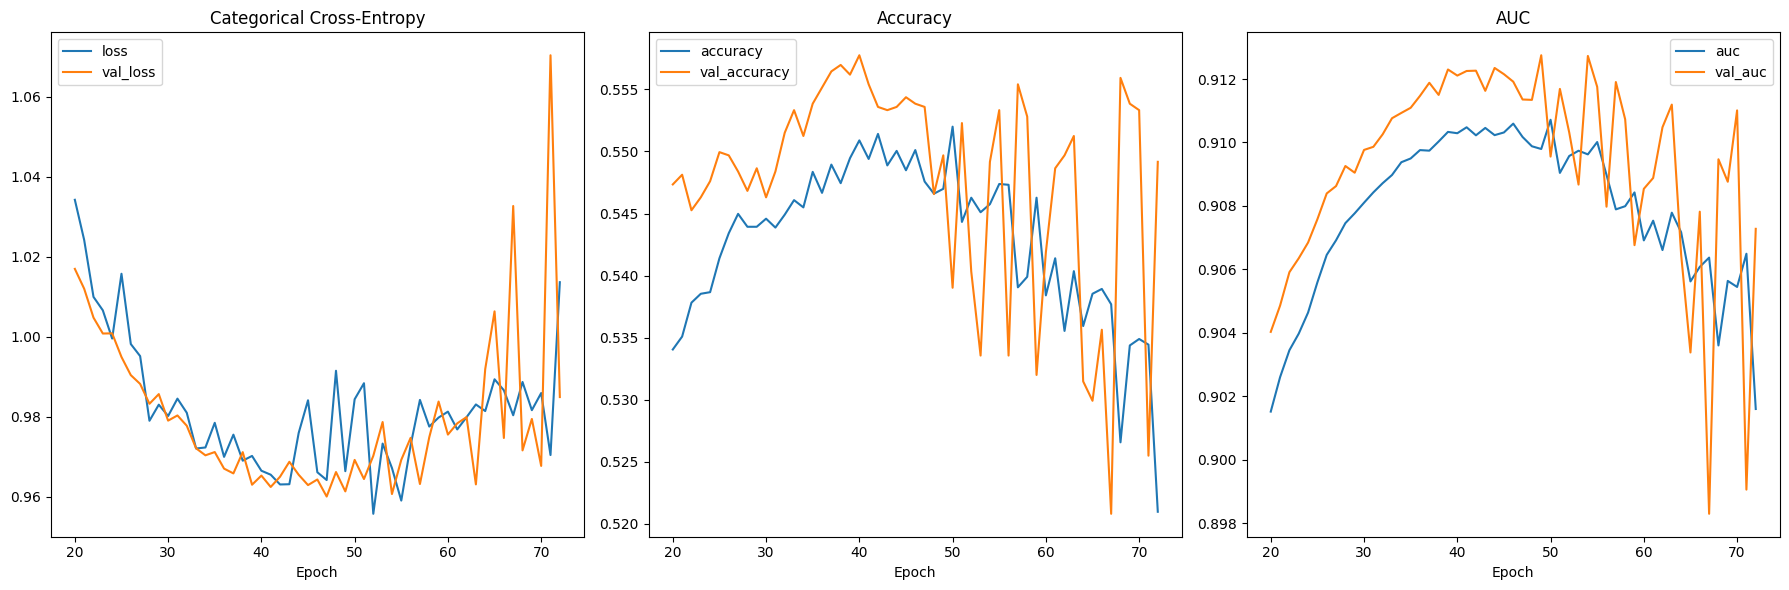

New model: Lemon with layers: [128, 64, 32]
Epochs until best result: 46
Best validation accuracy: 0.5504682660102844
Best validation auc     : 0.9095516800880432
Best validation loss    : 0.9641711711883545


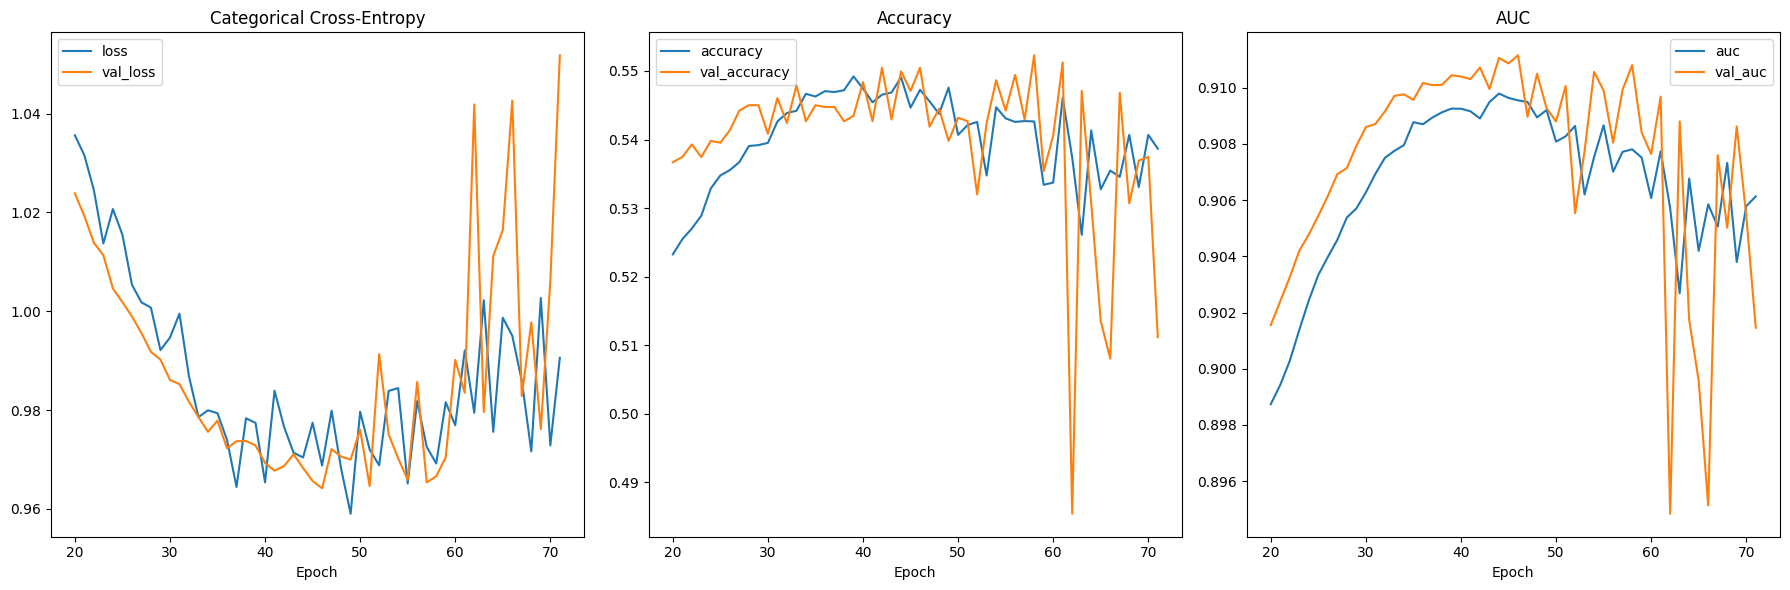

In [9]:
layers_list = [
    [16,16,16],
    [16,16,16,16],
    [16,16,16,16,16],
    [32,16,16],
    [32,16,16,16],
    [32,16,16,16,16],
    [32,32,16],
    [32,32,32],
    [64,16,16],
    [64,32,16],
    [64,32,32],
    [64,64,16],
    [64,64,64],
    [128,16,16],
    [128,32,16],
    [128,32,32],
    [128,64,16],
    [128,64,32]
]

best_model = None
best_layers = None
min_loss = 99999999.0

for layers in layers_list: 
    # Get a new model, although keep the learning rate at 0.0001
    model = get_model(learning_rate=0.0001,layers=layers)
    print(f'New model: {model.name} with layers: {layers}')
    # Train the model
    model,history = train_model(model)
    # Plot the metrics
    print_metrics(history)
    plot_metrics(history,start=20)
    
    if min(history.history['val_loss']) < min_loss:
        min_loss = min(history.history['val_loss'])
        best_model = model
        best_layers = layers

In [10]:
print(f'least validation loss: {min_loss} achived with {best_layers}')
best_model.summary()

least validation loss: 0.9473357796669006 achived with [128, 32, 32]


Model: "Lemon"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_74 (Dense)                │ (None, 128)            │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,999 (105.47 KB)

 Trainable params: 8,999 (35.15 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,000 (70.32 KB)

In [11]:
model = best_model

### Conclusion
Seeing that many models had greater results when having a 16 unit layer as second to last I would guess that it could improve our model to add such a layer. But looking at our results above, deeper network seem to increase over-fitting. However, adding techniques such as batch-normalization and drop-out could help balance the over-fitting as well as improve the training on our quite inbalanced data. 

In [12]:
# Train and submit
X_test = test_data
X_test[cols_to_std] = my_preprocessor.transform(test_data)
y_hat = model.predict(X_test)

401/401 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step


In [13]:
output = pd.DataFrame(y_hat, columns=y_train.columns, index=test_data.index)
print(output.head())
output.to_csv('submission_lemon_004.csv', index=True)

         Pastry  Z_Scratch  K_Scatch    Stains  Dirtiness     Bumps  \
id                                                                    
19219  0.344886   0.002119  0.003096  0.000352   0.050924  0.191292   
19220  0.200369   0.045513  0.038726  0.003334   0.132488  0.240704   
19221  0.013587   0.032077  0.080928  0.035194   0.023885  0.309749   
19222  0.082804   0.008182  0.002385  0.002377   0.012905  0.472136   
19223  0.018156   0.005093  0.005672  0.002918   0.007281  0.576021   

       Other_Faults  
id                   
19219      0.407331  
19220      0.338867  
19221      0.504580  
19222      0.419211  
19223      0.384859  
